In [1]:
import os
import torch
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from typing import Any, Dict, Type, cast
from sharp_dataloader import GenMARSH, RandomRotation, Resize, gen_weights, GenMARSH_prediction
from torch.utils.data import DataLoader
from os.path import dirname as up
import pandas as pd
import smp_metrics
from torchmetrics import Accuracy, JaccardIndex, MetricCollection
from omegaconf import OmegaConf
from pathlib import Path
import rasterio

import numpy as np
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision import transforms
import itertools 
import tqdm
import time

import warnings


from torch.optim.lr_scheduler import ReduceLROnPlateau
from sharp_trainer import SemanticSegmentationTask

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.loggers import TensorBoardLogger


path_cur = os.path.abspath(os.getcwd())
root_path = up(path_cur)
data_dir = os.path.join(root_path, 'data', 'NAIP')

import sys
sys.path.append(root_path)
from utils import metrics

In [163]:
NAIP_df[NAIP_df['valid']==1]

,file_path,file_name,filter_size,filter_zero,valid,prediction_path,generated,tile_name
47,/rapids/notebooks/sciclone/geograd/Miranda/VIM...,m_3607501_sw_18_060_20180827_tile_256-256.tif,1,1,1,/rapids/notebooks/sciclone/geograd/Miranda/git...,1,m_3607501_sw_18_060_20180827
48,/rapids/notebooks/sciclone/geograd/Miranda/VIM...,m_3607501_sw_18_060_20180827_tile_256-512.tif,1,1,1,/rapids/notebooks/sciclone/geograd/Miranda/git...,1,m_3607501_sw_18_060_20180827
49,/rapids/notebooks/sciclone/geograd/Miranda/VIM...,m_3607501_sw_18_060_20180827_tile_256-768.tif,1,1,1,/rapids/notebooks/sciclone/geograd/Miranda/git...,1,m_3607501_sw_18_060_20180827
50,/rapids/notebooks/sciclone/geograd/Miranda/VIM...,m_3607501_sw_18_060_20180827_tile_256-1024.tif,1,1,1,/rapids/notebooks/sciclone/geograd/Miranda/git...,1,m_3607501_sw_18_060_20180827
51,/rapids/notebooks/sciclone/geograd/Miranda/VIM...,m_3607501_sw_18_060_20180827_tile_256-1280.tif,1,1,1,/rapids/notebooks/sciclone/geograd/Miranda/git...,1,m_3607501_sw_18_060_20180827
...,...,...,...,...,...,...,...,...
708100,/rapids/notebooks/sciclone/geograd/Miranda/VIM...,m_3807764_ne_18_060_20180828_tile_11520-9984.tif,1,1,1,/rapids/notebooks/sciclone/geograd/Miranda/git...,1,m_3807764_ne_18_060_20180828
708101,/rapids/notebooks/sciclone/geograd/Miranda/VIM...,m_3807764_ne_18_060_20180828_tile_11520-10240.tif,1,1,1,/rapids/notebooks/sciclone/geograd/Miranda/git...,1,m_3807764_ne_18_060_20180828
708102,/rapids/notebooks/sciclone/geograd/Miranda/VIM...,m_3807764_ne_18_060_20180828_tile_11520-10496.tif,1,1,1,/rapids/notebooks/sciclone/geograd/Miranda/git...,1,m_3807764_ne_18_060_20180828
708103,/rapids/notebooks/sciclone/geograd/Miranda/VIM...,m_3807764_ne_18_060_20180828_tile_11520-10752.tif,1,1,1,/rapids/notebooks/sciclone/geograd/Miranda/git...,1,m_3807764_ne_18_060_20180828


In [12]:
root_path

'/rapids/notebooks/sciclone/geograd/Miranda/github/MarshMapping'

In [13]:
NAIP_path = Path(os.path.join(up(path_cur), 'data/NAIP/all_NAIP_2018.csv'))
pred_df = pd.read_csv(NAIP_path)

prediction_path = os.path.join(root_path, 'output_prediction')

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                Resize(256)])

# load data
dataset = GenMARSH_prediction(NAIP_path, transform=transform, ndvi=True)

testloader = DataLoader(dataset, 
                batch_size = 1, 
                shuffle = False,
                num_workers = 0,
                pin_memory = False)

In [4]:
# get some random prediction images

dataiter = iter(testloader)
batch = dataiter.next()

In [5]:
batch['image'].shape

torch.Size([1, 5, 256, 256])

m_3607501_sw_18_060_20180827_tile_256-256.tif


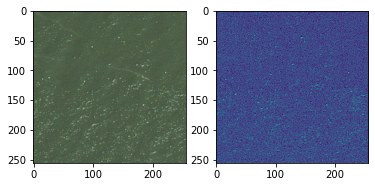

m_3607501_sw_18_060_20180827_tile_256-512.tif


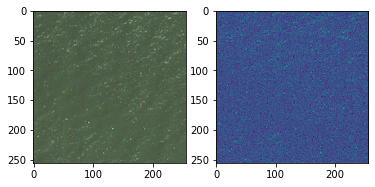

m_3607501_sw_18_060_20180827_tile_256-768.tif


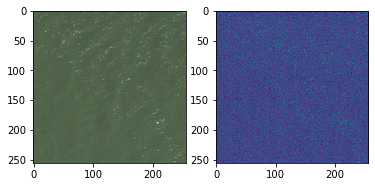

m_3607501_sw_18_060_20180827_tile_256-1024.tif


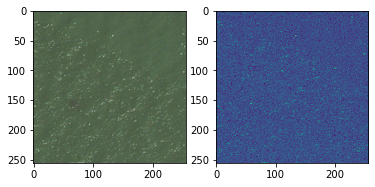

m_3607501_sw_18_060_20180827_tile_256-1280.tif


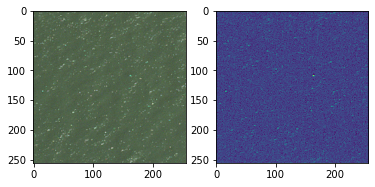

m_3607501_sw_18_060_20180827_tile_256-1536.tif


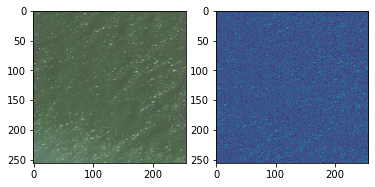

m_3607501_sw_18_060_20180827_tile_256-1792.tif


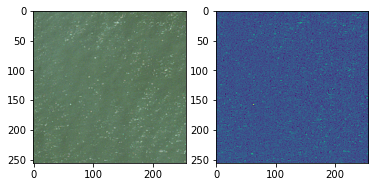

m_3607501_sw_18_060_20180827_tile_256-2048.tif


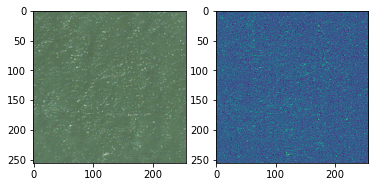

m_3607501_sw_18_060_20180827_tile_256-2304.tif


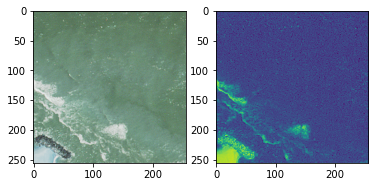

m_3607501_sw_18_060_20180827_tile_256-2560.tif


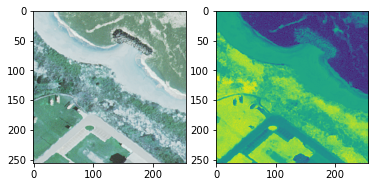

m_3607501_sw_18_060_20180827_tile_256-2816.tif


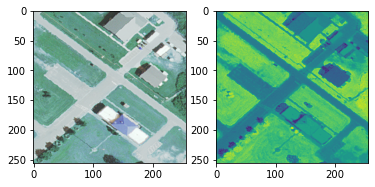

In [6]:
import numpy as np
import matplotlib.pyplot as plt    

def display_NAIP(image):
    
    # reshape data

    ndata = np.moveaxis(np.array(image), 0, -1)  # ndata is of shape (40, 40, 13)

    # select RGB (or any other combination)
    rgb = ndata[...,[2,1,0]]
    ndvi = ndata[...,-1] # this is not ndvi value
    
    f = plt.figure()
    f.add_subplot(1,2,1)
    plt.imshow(rgb)
    
    f.add_subplot(1,2,2)
    plt.imshow(ndvi)
    
    plt.show(block=True)



for i in range(20):
    
    # the input is a tensor
    sample = dataset[i]['image']
    print(dataset[i]['image_name'])
    display_NAIP(sample)

    if i == 10:
        break

In [15]:
def get_rasterinfo(img_path, predict_array, outputfile):
    
    rst = rasterio.open(img_path)
    meta = rst.meta.copy()
    meta.update(compress='lzw')
    meta['count'] = 1
    
    with rasterio.open(outputfile, 'w+', **meta) as out:
        out.write_band(1, predict_array)




In [ ]:

start_time = time.time()


for m in os.listdir(os.path.join(root_path, 'outputs', 'outputs_binary_tmi_naip')):
    if not m.endswith('ipynb_checkpoints') and ('NDVI' in m and 'unet' in m and 'val_loss' in m):
        print("Working on {}".format(m))
        start_time = time.time()
        mpath = os.path.join(root_path, 'outputs', 'outputs_binary_tmi_naip', m, 'last.ckpt')
        model = SemanticSegmentationTask.load_from_checkpoint(mpath)
        model.eval()
        
        output_dir = os.path.join(prediction_path, m)
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        with torch.no_grad():
            
            for batch in testloader:

                image_array = batch['image']
                image_path = batch['image_path'][0]
                image_name = batch['image_name'][0]
                predict_path = os.path.join(output_dir, image_name)
    
                logit = model(torch.Tensor(image_array)) # predicted
                logit = torch.nn.functional.softmax(logit, dim=1).argmax(1)[0]

                get_rasterinfo(image_path, logit, predict_path)
                
                
end_time = time.time()
diff = end_time - start_time

Working on SegmentationModel_val_loss_unet_resnet34_0.0001_ce_imagenet_NDVI
